# Model Comparison

This notebook compares the performance of all models trained for the **expected goals (xG)** task.  
The baseline model is **Linear Regression** (trained on DS3), while **Random Forest**, **XGBoost**, and **Neural Network (MLP)** are trained on DS4.  

The comparison focuses on the following aspects:

- **Quantitative metrics**: RMSE, MAE, R², Explained Variance, Pearson and Spearman correlation.  

- **Calibration analysis**: how well predicted probabilities align with observed outcomes. 

- **Overfitting check**: difference between training and test performance.  

- **Feature importance**: interpretation of influential features (where applicable).  

This analysis allows to identify the best-performing model, evaluate calibration and generalization.

#### Imports and Global Settings

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Paths
OUTPUT_DIR = "../task1_xg/outputs"
MODEL_DIR = "../task1_xg/models"

print("Setup complete. Ready to load metrics.")

Setup complete. Ready to load metrics.


#### Load Saved Metrics

In [16]:
# Load metrics saved from individual model notebooks
lin_metrics = pd.read_csv(f"{OUTPUT_DIR}/metrics_linear_regression.csv", index_col=0)
rf_metrics  = pd.read_csv(f"{OUTPUT_DIR}/metrics_rf.csv", index_col=0)
xgb_metrics = pd.read_csv(f"{OUTPUT_DIR}/metrics_xgboost.csv", index_col=0)
# nn_metrics   = pd.read_csv(f"{OUTPUT_DIR}/metrics_nn.csv", index_col=0)  # to add after NN is trained

# Concatenate all results
all_metrics = pd.concat([lin_metrics, rf_metrics, xgb_metrics], axis=0)

all_metrics

,RMSE,MAE,R2,ExplainedVar,Pearson,Spearman
Linear Regression (train),0.0661,0.0419,0.7314,0.7314,0.8552,0.8527
Linear Regression (test),0.0697,0.0429,0.7164,0.7164,0.8465,0.8589
Random Forest (train),0.0146,0.0072,0.9869,0.9869,0.9938,0.9949
Random Forest (test),0.0402,0.0199,0.9055,0.9055,0.9517,0.9696
XGBoost (train),0.0274,0.0148,0.9537,0.9537,0.9771,0.9754
XGBoost (test),0.0394,0.0193,0.9093,0.9093,0.9542,0.9715


#### Overfitting Check

In [ ]:
import pandas as pd

# Reset index so we can split Model and Dataset
all_metrics = all_metrics.reset_index().rename(columns={"index": "ModelSet"})

# Split "Model (train/test)" into "Model" and "Set"
all_metrics["Set"] = all_metrics["ModelSet"].apply(lambda x: "train" if "train" in x else "test")
all_metrics["Model"] = all_metrics["ModelSet"].apply(lambda x: x.replace(" (train)", "").replace(" (test)", ""))

all_metrics = all_metrics.drop(columns=["ModelSet"])

# Pivot: each model has train/test side by side
metrics_pivot = all_metrics.pivot_table(
    index="Model",
    columns="Set",
    values=["RMSE", "MAE", "R2", "ExplainedVar", "Pearson", "Spearman"]
)

# Compute differences: Δ = Test - Train
delta_df = pd.DataFrame()
for metric in ["RMSE", "MAE", "R2", "ExplainedVar", "Pearson", "Spearman"]:
    delta_df["Δ" + metric] = (
        metrics_pivot[metric]["test"] - metrics_pivot[metric]["train"]
    )

print("\nOverfitting check (Δ = Test - Train):")
display(delta_df)


Overfitting check (Δ = Test - Train):


,ΔRMSE,ΔMAE,ΔR2,ΔExplainedVar,ΔPearson,ΔSpearman
Model,,,,,,
Linear Regression,0.0036,0.0010,-0.0151,-0.0150,-0.0087,0.0062
Random Forest,0.0256,0.0127,-0.0814,-0.0814,-0.0420,-0.0254
XGBoost,0.0120,0.0046,-0.0444,-0.0444,-0.0228,-0.0039


#### Compare Metrics

In [18]:
# Sort by RMSE (lower is better)
all_metrics_sorted = all_metrics.sort_values(by="RMSE")
display(all_metrics_sorted)

print("\nBest model by RMSE (lower is better):")
print(all_metrics_sorted.head(1))

,ModelSet,RMSE,MAE,R2,ExplainedVar,Pearson,Spearman,Set,Model
2,Random Forest (train),0.0146,0.0072,0.9869,0.9869,0.9938,0.9949,train,Random Forest
4,XGBoost (train),0.0274,0.0148,0.9537,0.9537,0.9771,0.9754,train,XGBoost
5,XGBoost (test),0.0394,0.0193,0.9093,0.9093,0.9542,0.9715,test,XGBoost
3,Random Forest (test),0.0402,0.0199,0.9055,0.9055,0.9517,0.9696,test,Random Forest
0,Linear Regression (train),0.0661,0.0419,0.7314,0.7314,0.8552,0.8527,train,Linear Regression
1,Linear Regression (test),0.0697,0.0429,0.7164,0.7164,0.8465,0.8589,test,Linear Regression



Best model by RMSE (lower is better):
                ModelSet   RMSE    MAE     R2  ExplainedVar  Pearson  \
2  Random Forest (train) 0.0146 0.0072 0.9869        0.9869   0.9938   

   Spearman    Set          Model  
2    0.9949  train  Random Forest  


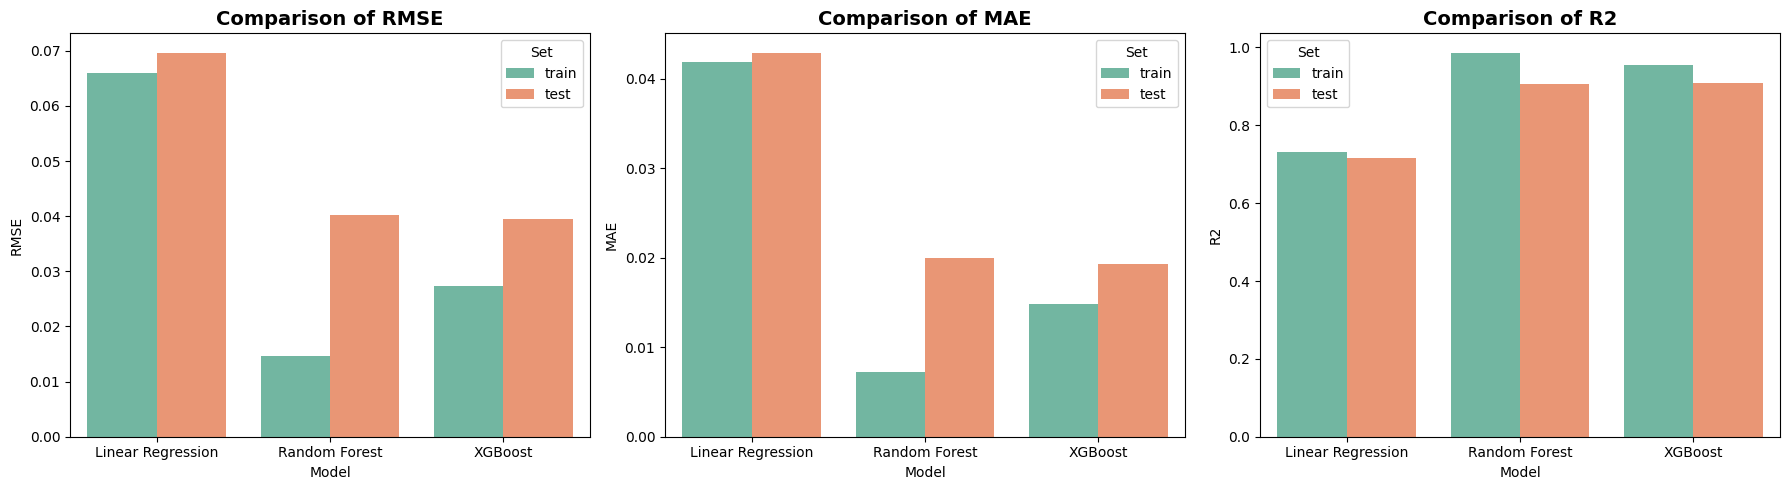

In [40]:
# Lista metriche da plottare
metrics = ["RMSE", "MAE", "R2"]

# Figura con sottoplot
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5), sharey=False)

for i, metric in enumerate(metrics):
    sns.barplot(
        data=all_metrics,
        x="Model",
        y=metric,
        hue="Set",          # train vs test
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(f"Comparison of {metric}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(metric)
    axes[i].legend(title="Set")

plt.tight_layout()
plt.show()


#### Calibration Analysis

Calibration curves are particularly important in the context of **expected goals (xG)**, since the output of the model is interpreted directly as the probability of scoring.  

Before analyzing calibration, the **distribution of `target_xg`** is inspected. The percentiles show that the vast majority of shots have very low xG, while high-probability shots are rare events. This imbalance explains why calibration curves typically align well in the low range and diverge in the upper bins: the model has limited training data for rare high-xG events, making those predictions harder to calibrate.


In [37]:
from sklearn.model_selection import train_test_split

ds3 = pd.read_csv(f"../task1_xg/data/DS3.csv")
ds4 = pd.read_csv(f"../task1_xg/data/DS4.csv")

# Define features and target
target_column = "target_xg"  # expected goals column
train_columns_ds3 = [col for col in ds3.columns if col != target_column]
train_columns_ds4 = [col for col in ds4.columns if col != target_column]

X_ds3 = ds3[train_columns_ds3]
y_ds3 = ds3[target_column]

X_ds4 = ds4[train_columns_ds4]
y_ds4 = ds4[target_column]

# Split into train and test sets
X_train_ds3, X_test_ds3, y_train_ds3, y_test_ds3 = train_test_split(
    X_ds3, y_ds3, test_size=0.2, random_state=RANDOM_STATE
)

X_train_ds4, X_test_ds4, y_train_ds4, y_test_ds4 = train_test_split(
    X_ds4, y_ds4, test_size=0.2, random_state=RANDOM_STATE
)

print("DS3:")
print(f"Dataset: {X_ds3.shape[0]} rows, {X_ds3.shape[1]} features")
print(f"Training set: {X_train_ds3.shape[0]} rows")
print(f"Test set: {X_test_ds3.shape[0]} rows")

print("\nDS4:")
print(f"Dataset: {X_ds4.shape[0]} rows, {X_ds4.shape[1]} features")
print(f"Training set: {X_train_ds4.shape[0]} rows")
print(f"Test set: {X_test_ds4.shape[0]} rows")


DS3:
Dataset: 86833 rows, 42 features
Training set: 69466 rows
Test set: 17367 rows

DS4:
Dataset: 86833 rows, 25 features
Training set: 69466 rows
Test set: 17367 rows


Distribution of target_xg:
count   86,833.0000
mean         0.0973
std          0.1281
min          0.0002
1%           0.0059
5%           0.0085
10%          0.0140
25%          0.0275
50%          0.0540
75%          0.1060
90%          0.2310
95%          0.3617
99%          0.6884
max          0.9951
Name: target_xg, dtype: float64


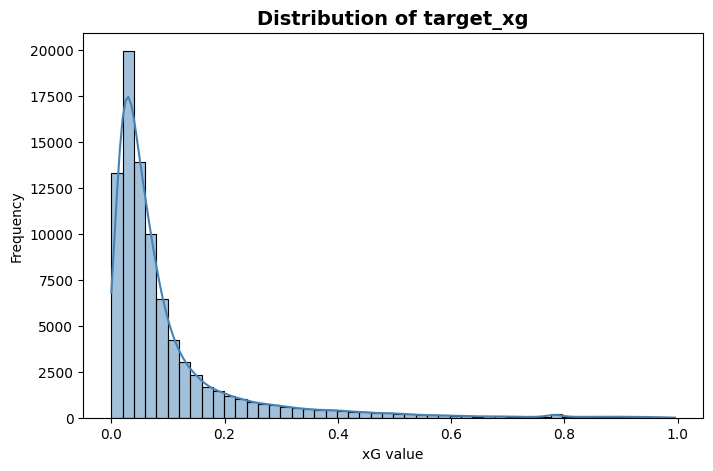

In [36]:
# Distribution analysis of target_xg
percentiles = y_ds3.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("Distribution of target_xg:")
print(percentiles)

plt.figure(figsize=(8,5))
sns.histplot(y_ds3, bins=50, kde=True, color="steelblue")
plt.title("Distribution of target_xg", fontsize=14, fontweight="bold")
plt.xlabel("xG value")
plt.ylabel("Frequency")
plt.show()

In [25]:
import joblib
import numpy as np

# Load models
lin_reg = joblib.load(f"{MODEL_DIR}/model_linear_regression.pkl")
rf_model = joblib.load(f"{MODEL_DIR}/model_rf.pkl")
xgb_model = joblib.load(f"{MODEL_DIR}/model_xgboost.pkl")
# nn_model  = joblib.load(f"{MODEL_DIR}/model_nn.pkl") 

# Predictions
# DS3 for linear regression
y_lin_pred = lin_reg.predict(X_test_ds3)

# DS4 for RF, XGB, NN
y_rf_pred  = rf_model.predict(X_test_ds4)
y_xgb_pred = xgb_model.predict(X_test_ds4)
# y_nn_pred  = nn_model.predict(X_test_ds4)

print("Predictions ready for calibration analysis.")


Predictions ready for calibration analysis.


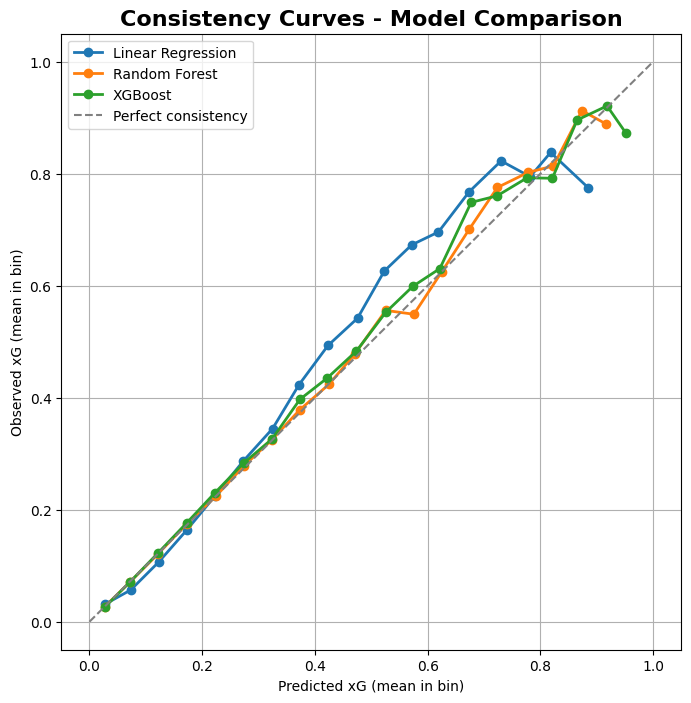

In [ ]:
def plot_calibration_xg(y_true, y_pred, n_bins=20, label=None):
    """
    Consistency check between predicted xG (y_pred) and true xG (y_true)
    Since y_true is continuous [0,1], the average of y_true per prediction bin is computed
    """
    # Create equally spaced bins between 0 and 1
    bins = np.linspace(0, 1, n_bins + 1)            # bins: [0.0, 0.05, 0.1, ..., 1.0]
    bin_ids = np.digitize(y_pred, bins) - 1         # bin_ids: [0, 0, 1, 2, ..., n_bins-1]

    bin_true = []
    bin_pred = []

    for i in range(n_bins):
        mask = bin_ids == i
        if np.any(mask):

            # Average of predicted values in the bin
            bin_pred.append(y_pred[mask].mean())
            
            # Average of true xG values in the bin
            bin_true.append(y_true[mask].mean())

    # Plot curve
    plt.plot(bin_pred, bin_true, marker='o', label=label, linewidth=2)

plt.figure(figsize=(8, 8))

plot_calibration_xg(y_test_ds3, y_lin_pred, label="Linear Regression")
plot_calibration_xg(y_test_ds4, y_rf_pred,  label="Random Forest")
plot_calibration_xg(y_test_ds4, y_xgb_pred, label="XGBoost")
# plot_calibration_xg(y_test_ds4, y_nn_pred,  label="Neural Network")

# Reference line = perfect consistency
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect consistency")

plt.xlabel("Predicted xG (mean in bin)")
plt.ylabel("Observed xG (mean in bin)")
plt.title("Consistency Curves - Model Comparison", fontsize=16, fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()


## Conclusion